In [14]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

In [2]:
processed_recession_df = pd.read_csv('../data/processed/recession_probability.csv')

In [3]:
processed_recession_df.columns

Index(['date', 'recession_probability', '1_month_recession_probability',
       '3_month_recession_probability', '6_month_recession_probability',
       '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
       '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
       'OECD_CLI_index', 'CSI_index', 'Year', 'Quarter_Number', 'Month_Number',
       'gdp_per_capita', 'seasonally_adjusted_INDPRO',
       'seasonally_adjusted_CPI', 'seasonally_adjusted_unemployment_rate',
       'anomaly_INDPRO', 'anomaly_CPI', 'anomaly_unemployment_rate',
       'anomaly_PPI', 'anomaly_share_price', 'anomaly_1_year_rate',
       'anomaly_3_months_rate', 'anomaly_6_months_rate',
       'anomaly_10_year_rate', 'CPI_trend', 'INDPRO_trend',
       'unemployment_rate_trend', 'PPI_trend', 'seasonally_adjusted_PPI'],
      dtype='object')

In [7]:
# Assuming processed_recession_df is already loaded

acf_columns = [
    '1_year_rate', 
    '3_months_rate', 
    '6_months_rate', 
    'CPI', 
    'INDPRO', 
    '10_year_rate', 
    'share_price', 
    'unemployment_rate', 
    'PPI', 
    'OECD_CLI_index', 
    'CSI_index', 
    'gdp_per_capita'
]

def get_acf_features(series, nlags=10, seasonal_lag=None):
    series = pd.Series(series).dropna()

    acf_original = acf(series, nlags=nlags, fft=False)
    first_acf_original = acf_original[1]
    sumsq_acf_original = np.sum(acf_original[1:11] ** 2)

    diff1 = series.diff().dropna()
    acf_diff1 = acf(diff1, nlags=nlags, fft=False)
    first_acf_diff1 = acf_diff1[1]
    sumsq_acf_diff1 = np.sum(acf_diff1[1:11] ** 2)

    diff2 = diff1.diff().dropna()
    acf_diff2 = acf(diff2, nlags=nlags, fft=False)
    first_acf_diff2 = acf_diff2[1]
    sumsq_acf_diff2 = np.sum(acf_diff2[1:11] ** 2)

    seasonal_acf = None
    if seasonal_lag is not None and seasonal_lag < len(acf_original):
        seasonal_acf = acf_original[seasonal_lag]

    return [
        first_acf_original,
        sumsq_acf_original,
        first_acf_diff1,
        sumsq_acf_diff1,
        first_acf_diff2,
        sumsq_acf_diff2,
        seasonal_acf
    ]


# Compute features and store in new columns only for acf_columns
for col in acf_columns:
    f1, f2, f3, f4, f5, f6, f7 = get_acf_features(
        processed_recession_df[col],
        nlags=10,
        seasonal_lag=12  # For monthly data
    )
    processed_recession_df[f"{col}_acf1_original"] = f1
    processed_recession_df[f"{col}_sumsq_acf_original"] = f2
    processed_recession_df[f"{col}_acf1_diff1"] = f3
    processed_recession_df[f"{col}_sumsq_acf_diff1"] = f4
    processed_recession_df[f"{col}_acf1_diff2"] = f5
    processed_recession_df[f"{col}_sumsq_acf_diff2"] = f6
    processed_recession_df[f"{col}_acf_seasonal"] = f7

print(processed_recession_df.head())


         date  recession_probability  1_month_recession_probability  \
0  1967-02-01                    NaN                            NaN   
1  1967-03-01                    NaN                            NaN   
2  1967-04-01                    NaN                            NaN   
3  1967-05-01                    NaN                            0.8   
4  1967-06-01                    0.8                            0.5   

   3_month_recession_probability  6_month_recession_probability  1_year_rate  \
0                            NaN                           0.00     4.574444   
1                           0.80                           0.26     4.185000   
2                           0.50                           0.08     3.898500   
3                           0.00                           0.00     3.885000   
4                           0.26                           0.00     4.164545   

   3_months_rate  6_months_rate   CPI   INDPRO  ...  CSI_index_acf1_diff2  \
0       4.56111

In [8]:
processed_recession_df.columns

Index(['date', 'recession_probability', '1_month_recession_probability',
       '3_month_recession_probability', '6_month_recession_probability',
       '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
       ...
       'CSI_index_acf1_diff2', 'CSI_index_sumsq_acf_diff2',
       'CSI_index_acf_seasonal', 'gdp_per_capita_acf1_original',
       'gdp_per_capita_sumsq_acf_original', 'gdp_per_capita_acf1_diff1',
       'gdp_per_capita_sumsq_acf_diff1', 'gdp_per_capita_acf1_diff2',
       'gdp_per_capita_sumsq_acf_diff2', 'gdp_per_capita_acf_seasonal'],
      dtype='object', length=121)

In [9]:
processed_recession_df.to_csv('../data/feature-engineered/recession_probability.csv', index=False)

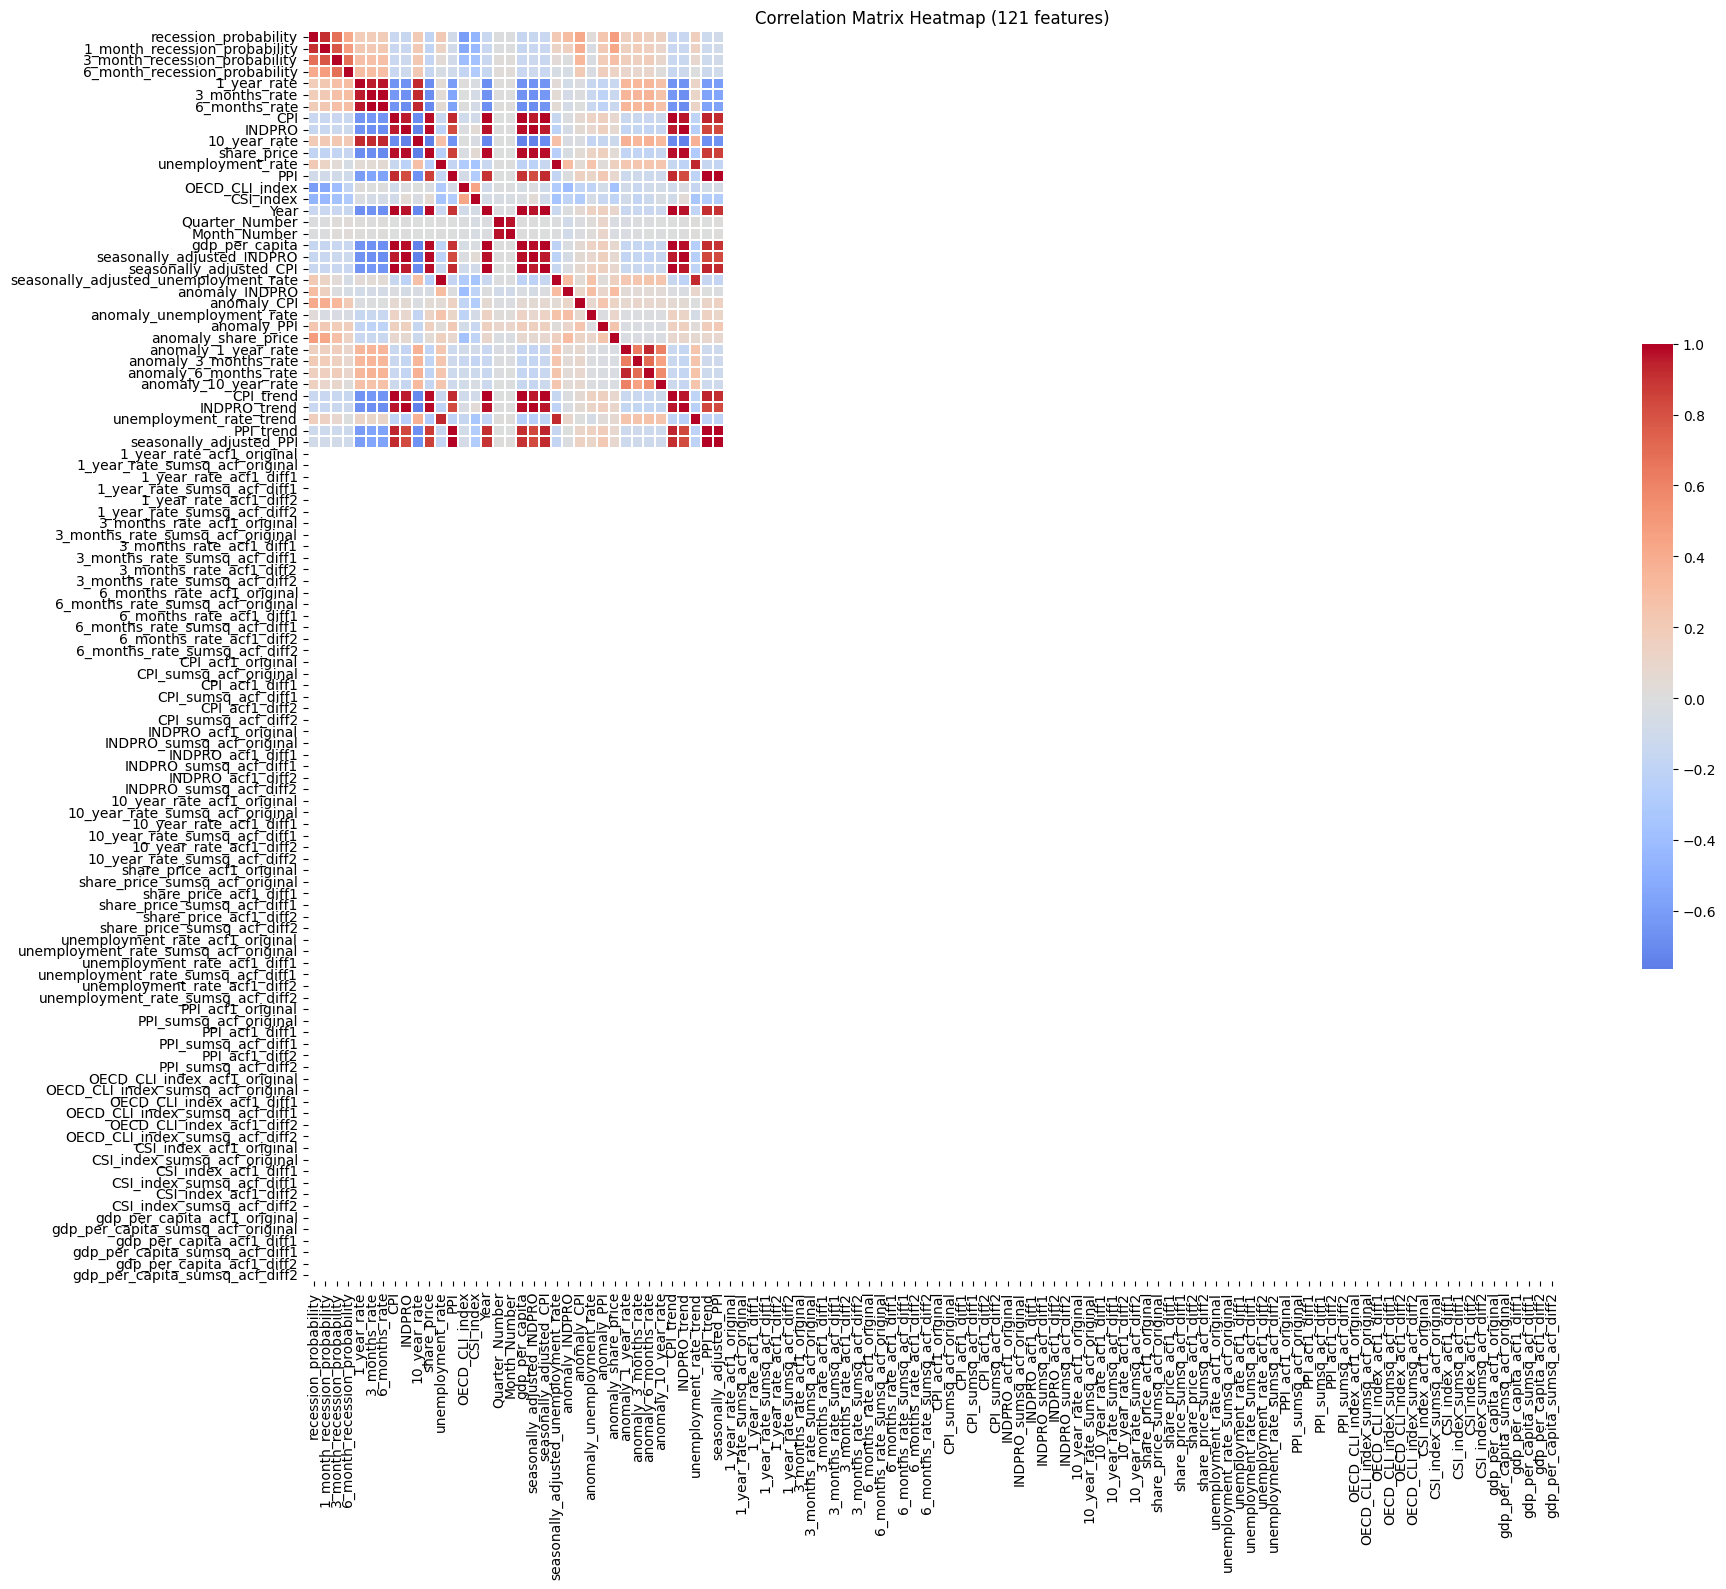

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 16))  # Bigger figure for 121 columns

sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.2,
    cbar_kws={"shrink": 0.5},
    xticklabels=True,
    yticklabels=True
)

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Correlation Matrix Heatmap (121 features)")
plt.tight_layout()
plt.show()

In [23]:
processed_recession_df.shape

(700, 121)

In [27]:
# Compute correlation matrix of numeric columns
corr_matrix = processed_recession_df.select_dtypes(include='number').corr().abs()

# Select upper triangle of correlation matrix without diagonal
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find pairs with correlation > 0.9
high_corr_pairs = (
    upper_tri.stack()
    .reset_index()
    .rename(columns={0: 'correlation'})
    .query('correlation > 0.9')
    .sort_values(by='correlation', ascending=False)
)

# Print nicely
if not high_corr_pairs.empty:
    print(f"Found {len(high_corr_pairs)} highly correlated feature pairs (correlation > 0.9):\n")
    for idx, row in high_corr_pairs.iterrows():
        print(f"{row['level_0']} ↔ {row['level_1']}: {row['correlation']:.4f}")
else:
    print("No feature pairs found with correlation above 0.9.")

# Save to CSV
high_corr_pairs.to_csv('../data/feature-engineered/high_correlation_pairs.csv', index=False)
print("\nSaved the high correlation pairs to 'high_correlation_pairs.csv'.")

Found 65 highly correlated feature pairs (correlation > 0.9):

CPI ↔ seasonally_adjusted_CPI: 1.0000
INDPRO ↔ seasonally_adjusted_INDPRO: 1.0000
CPI ↔ CPI_trend: 0.9999
seasonally_adjusted_CPI ↔ CPI_trend: 0.9999
PPI ↔ seasonally_adjusted_PPI: 0.9992
INDPRO ↔ INDPRO_trend: 0.9986
seasonally_adjusted_INDPRO ↔ INDPRO_trend: 0.9986
3_months_rate ↔ 6_months_rate: 0.9982
unemployment_rate ↔ seasonally_adjusted_unemployment_rate: 0.9980
1_year_rate ↔ 6_months_rate: 0.9977
Year ↔ CPI_trend: 0.9959
CPI ↔ Year: 0.9956
Year ↔ seasonally_adjusted_CPI: 0.9956
PPI ↔ PPI_trend: 0.9950
PPI_trend ↔ seasonally_adjusted_PPI: 0.9943
Year ↔ gdp_per_capita: 0.9939
gdp_per_capita ↔ CPI_trend: 0.9929
1_year_rate ↔ 3_months_rate: 0.9928
gdp_per_capita ↔ seasonally_adjusted_CPI: 0.9927
CPI ↔ gdp_per_capita: 0.9927
share_price ↔ gdp_per_capita: 0.9878
share_price ↔ INDPRO_trend: 0.9833
INDPRO ↔ share_price: 0.9822
share_price ↔ seasonally_adjusted_INDPRO: 0.9821
share_price ↔ Year: 0.9803
gdp_per_capita ↔ INDPR